## Dependencias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

## Lectura de Datos

In [2]:
ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/chicago/Taxi_Trips.csv'

In [3]:
columnas = ['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
            'Trip Seconds', 'Trip Miles',  'Fare', 'Tips', 'Tolls', 'Extras',
            'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
            'Pickup Centroid Longitude',
            'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']


In [4]:
df = pd.read_csv(ruta,usecols=columnas,dtype=str)

In [5]:
df.shape

(438804, 17)

## Homologación de Tipos de Datos

In [6]:
df.columns = ['trip_id', 'taxi_id', 'trip_start_ts', 'trip_end_ts', 'trip_seconds', 'trip_miles',
              'fare', 'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company', 'pu_lat', 'pu_lon', 'do_lat', 'do_lon'
              ]


In [7]:
for c in ['trip_start_ts','trip_end_ts']:
    df[c] = pd.to_datetime(df[c],format='%m/%d/%Y %I:%M:%S %p')

In [8]:
for c in ['trip_seconds', 'trip_miles','fare', 'tips', 'tolls', 'extras', 'trip_total', 'pu_lat', 'pu_lon', 'do_lat', 'do_lon']:
    df[c] = pd.to_numeric(df[c], errors='coerce')


## Ventanas de observación y predicción

In [123]:
# Predecir el ingreso de la semana t+1 basado en las 3 semanas previas (incluyendo la semana de ancla)

In [9]:
df['sem'] = df['trip_start_ts'].map(lambda x:x.strftime('%Y%U'))

In [10]:
cat = df[['sem']].drop_duplicates().sort_values(by='sem').reset_index(drop=True)
cat['id_sem'] = cat.index+1
cat

,sem,id_sem
0,202252,1
1,202301,2
2,202302,3
3,202303,4
4,202304,5
5,202305,6


In [11]:
df = df.merge(cat,on=['sem'],how='inner').drop('sem',axis=1)

In [12]:
df.head()

,trip_id,taxi_id,trip_start_ts,trip_end_ts,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,company,pu_lat,pu_lon,do_lat,do_lon,id_sem
0,00b5f60947ce8cbf6d2ff4e34a017eaf8a0c4e7e,29f0036be86a5830f9f045527766d16967c8330b9da28e...,2022-12-31 00:15:00,2022-12-31 00:15:00,480.0,1.30,7.00,0.00,0.0,0.0,7.00,Cash,Top Cab Affiliation,41.899602,-87.633308,41.874005,-87.663518,1
1,043e150290698c4cb693e4aeb63601e23b7fca2e,992641c74ae28a22b5d72e1f9fcc89ebda221b88c7bb03...,2022-12-31 00:15:00,2022-12-31 00:15:00,360.0,0.00,11.00,2.67,0.0,0.0,13.67,Mobile,Flash Cab,41.874005,-87.663518,41.874005,-87.663518,1
2,07be774e62b1c83fa6757e73c17a036789469003,9b48ad5744e86450fb4db78e7095a6827bafc43a6a9d9a...,2022-12-31 00:15:00,2022-12-31 00:15:00,224.0,0.61,4.75,0.00,0.0,2.0,6.75,Cash,Sun Taxi,41.944227,-87.655998,41.944227,-87.655998,1
3,0e8b90681639669ce6046e1dfddb0b23a05eed12,bd54bee5660726988fc54355ab54fc7cfd5c3917d911f9...,2022-12-31 00:15:00,2022-12-31 00:45:00,1213.0,15.25,38.50,6.75,0.0,6.0,51.75,Mobile,Taxicab Insurance Agency Llc,41.980264,-87.913625,41.922686,-87.649489,1
4,0f202891cc891722a9cb38b57adf4ddb0b5a0d24,b71c6761efe32829e7e453b0c6fcb78a456a7d83c720c7...,2022-12-31 00:15:00,2022-12-31 00:30:00,758.0,0.00,13.40,2.00,0.0,0.0,15.40,Mobile,Flash Cab,41.899602,-87.633308,41.922686,-87.649489,1


In [13]:
vobs = 3
vpred = 1
step = 1
ini,fin = df['id_sem'].min(),df['id_sem'].max()
anclai,anclaf = ini+vobs-1,fin-vpred

for a in range(anclai,anclaf+1):
    print(f'para predecir la semana {a+vpred} voy a usar las semanas {list(range(a-vobs+1,a+1))}')


para predecir la semana 4 voy a usar las semanas [1, 2, 3]
para predecir la semana 5 voy a usar las semanas [2, 3, 4]
para predecir la semana 6 voy a usar las semanas [3, 4, 5]


## Ingeniería de características

In [14]:
#******************************Pasado******************************
# Total de millas recorridas en las últimas k semanas
# Hora donde más actividad tuvo en la últimas k semanas
# Cantidad de viajes realizados en las últimas k semanas
# Porcentaje promedio de propinas en las últimas k semanas
# Monto total de los viajes en las últimas k semanas 
# Velocidad media en las últimas k semanas 
#*******************************************************************

### Matriz de características $\mathcal{X}$

In [15]:
def ingX(df:pd.DataFrame,ancla:int,k:int)->pd.DataFrame:
    """Computa las características de la unidad muestral taxi para un ancla específica en el tiempo
    considerando 'k' ventanas hacia atrás (incluyendo la misma). Las anclas están en semanas.

    Args:
        df (pd.DataFrame): datos transaccionales de viajes .
        ancla (int): ancla de posicionamiento
        k (int): sub-ventana de observación

    Returns:
        pd.DataFrame: Matriz de características para el ancla específica y la sub-ventana de observación indicada.
    """
    aux = df[(df['id_sem']<=ancla)&(df['id_sem']>=(ancla-k+1))].copy().reset_index(drop=True)
    aux['speed'] = aux['trip_miles']/aux['trip_seconds']*1.6*3600
    aux['speed'] = np.where(np.isinf(aux['speed']),np.nan,aux['speed'])
    aux['pct_tips'] = aux['tips']/aux['trip_total']
    aux['hour'] = aux['trip_start_ts'].map(lambda x:x.hour)
    piv = aux[['taxi_id','hour']].assign(n=1).pivot_table(index='taxi_id',columns='hour',values='n',aggfunc='sum')
    piv[f'x_hour_with_most_activity_last_{k}_weeks'] = piv.idxmax(axis=1)
    piv = piv[[f'x_hour_with_most_activity_last_{k}_weeks']].reset_index()
    aux = aux.groupby('taxi_id').agg({'trip_miles':'sum','trip_start_ts':'count','pct_tips':'mean','trip_total':'sum','speed':'mean'})
    aux.columns = [f'x_total_miles_in_last_{k}_weeks',f'x_total_trips_in_last_{k}_weeks',f'x_avg_tip_pct_in_last_{k}_weeks',
                f'x_total_revenue_in_last_{k}_weeks',f'x_mean_speed_in_last_{k}_weeks']
    aux.reset_index(inplace=True)
    aux = aux.merge(piv,on='taxi_id',how='outer')
    aux.insert(1,'ancla',ancla)
    return aux

In [16]:
um = ['taxi_id','ancla']

In [132]:
for j,ancla in enumerate(range(anclai,anclaf+1)):
    for i,k in enumerate(range(step, vobs+step, step)):
        if i == 0:
            x = ingX(df,ancla,k).copy()
        else:
            x = x.merge(ingX(df,ancla,k),on=um,how='outer')
    if j == 0:
        X = x.copy()
    else:
        X = pd.concat([X,x],ignore_index=True)
X.shape

(6728, 20)

In [17]:
cruzar = lambda x,y: x.merge(y,on=um,how='outer')
apilar = lambda x,y: pd.concat([x,y],ignore_index=True)

In [18]:
X = reduce(apilar, map(lambda ancla: reduce(cruzar, map(lambda k: ingX(
    df, ancla, k), range(step, vobs+step, step))), range(anclai, anclaf+1)))
X.shape

(6728, 20)

### Vector de predicción $\vec{y}$

In [19]:
def ingY(df:pd.DataFrame,ancla:int)->pd.DataFrame:
    """Genera la variable objetivo (1 semana de revenue futuro)

    Args:
        df (pd.DataFrame): datos transaccionales de viajes .
        ancla (int): ancla de posicionamiento.

    Returns:
        pd.DataFrame: Vector de predicción para el ancla específica.
    """
    aux = df[(df['id_sem']>ancla)&(df['id_sem']<=(ancla+vpred))].copy().reset_index(drop=True)
    aux = aux[['taxi_id','trip_total']] .groupby('taxi_id').sum().reset_index()
    aux.columns = ['taxi_id','target_revenue']
    aux.insert(1,'ancla',ancla)
    return aux

In [20]:
y = reduce(apilar,map(lambda ancla:ingY(df,ancla),range(anclai,anclaf+1)))

In [21]:
y.ancla.unique()

array([3, 4, 5])

### Conjunto de entrenamiento

In [22]:
Sn = X.merge(y,on=um,how='inner')
Sn.shape

(6131, 21)

In [23]:
Sn.head()

,taxi_id,ancla,x_total_miles_in_last_1_weeks,x_total_trips_in_last_1_weeks,x_avg_tip_pct_in_last_1_weeks,x_total_revenue_in_last_1_weeks,x_mean_speed_in_last_1_weeks,x_hour_with_most_activity_last_1_weeks,x_total_miles_in_last_2_weeks,x_total_trips_in_last_2_weeks,...,x_total_revenue_in_last_2_weeks,x_mean_speed_in_last_2_weeks,x_hour_with_most_activity_last_2_weeks,x_total_miles_in_last_3_weeks,x_total_trips_in_last_3_weeks,x_avg_tip_pct_in_last_3_weeks,x_total_revenue_in_last_3_weeks,x_mean_speed_in_last_3_weeks,x_hour_with_most_activity_last_3_weeks,target_revenue
0,0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...,3,19.40,76.0,0.032758,1257.85,1.195370,15.0,32.50,126.0,...,2070.60,1.227607,15.0,32.50,126,0.023815,2070.60,1.227607,15,999.75
1,0044e6c0d091476299b99345501f756b23632a96cbaf40...,3,440.97,60.0,0.104918,1719.76,28.837141,11.0,762.68,128.0,...,3031.18,26.921582,8.0,864.38,160,0.122853,3556.60,26.375385,8,1317.95
2,00752524a4118a162dce62ff49c0eb0f79530d9e0ecb5a...,3,193.50,19.0,0.113661,844.25,56.750367,20.0,489.10,43.0,...,2063.51,53.433208,0.0,609.90,53,0.111295,2457.91,53.830828,0,916.70
3,0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4...,3,23.10,80.0,0.041170,1515.80,1.417916,18.0,30.20,104.0,...,1980.10,1.453477,14.0,37.00,116,0.040621,2367.60,1.509979,14,1456.33
4,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,3,391.80,117.0,0.088767,1635.55,28.197377,11.0,777.80,218.0,...,3080.04,29.190599,10.0,907.80,256,0.066669,3573.44,29.662902,10,1924.55


In [25]:
Sn.shape

(6131, 21)

In [55]:
Sn.to_parquet('taxis.parquet')

In [2]:
x= pd.read_clipboard()

In [3]:
x

,Estatura
0,176
1,160
2,170
3,173
4,163
5,176
6,172
7,167
8,160
9,172


In [4]:
xp = np.random.normal(167.76,10.6077016,size=25)

In [5]:
data = pd.DataFrame({'x':x['Estatura'],'xp':xp})

<Axes: ylabel='Density'>

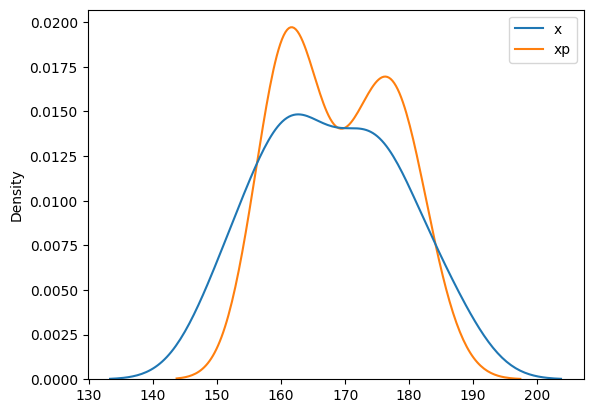

In [6]:
sns.kdeplot(data)

<Axes: ylabel='Density'>

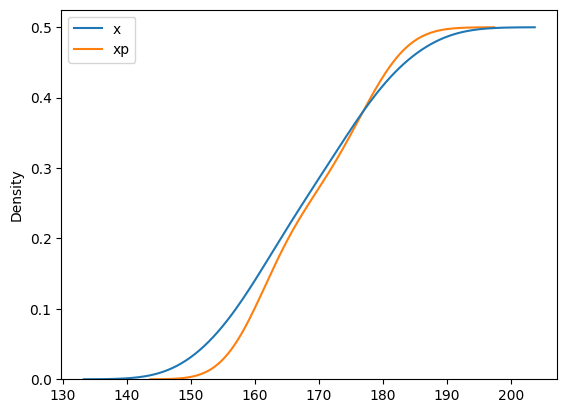

In [7]:
sns.kdeplot(data,cumulative=True)